# Metadata

Model number of shootings per state given political spending by party in a given state.  

Data Sources: 

    Gun Violence Awareness  
    Political Media Spending (3rd party) from 2020 Presidential General Election

Modeling based on the following:  
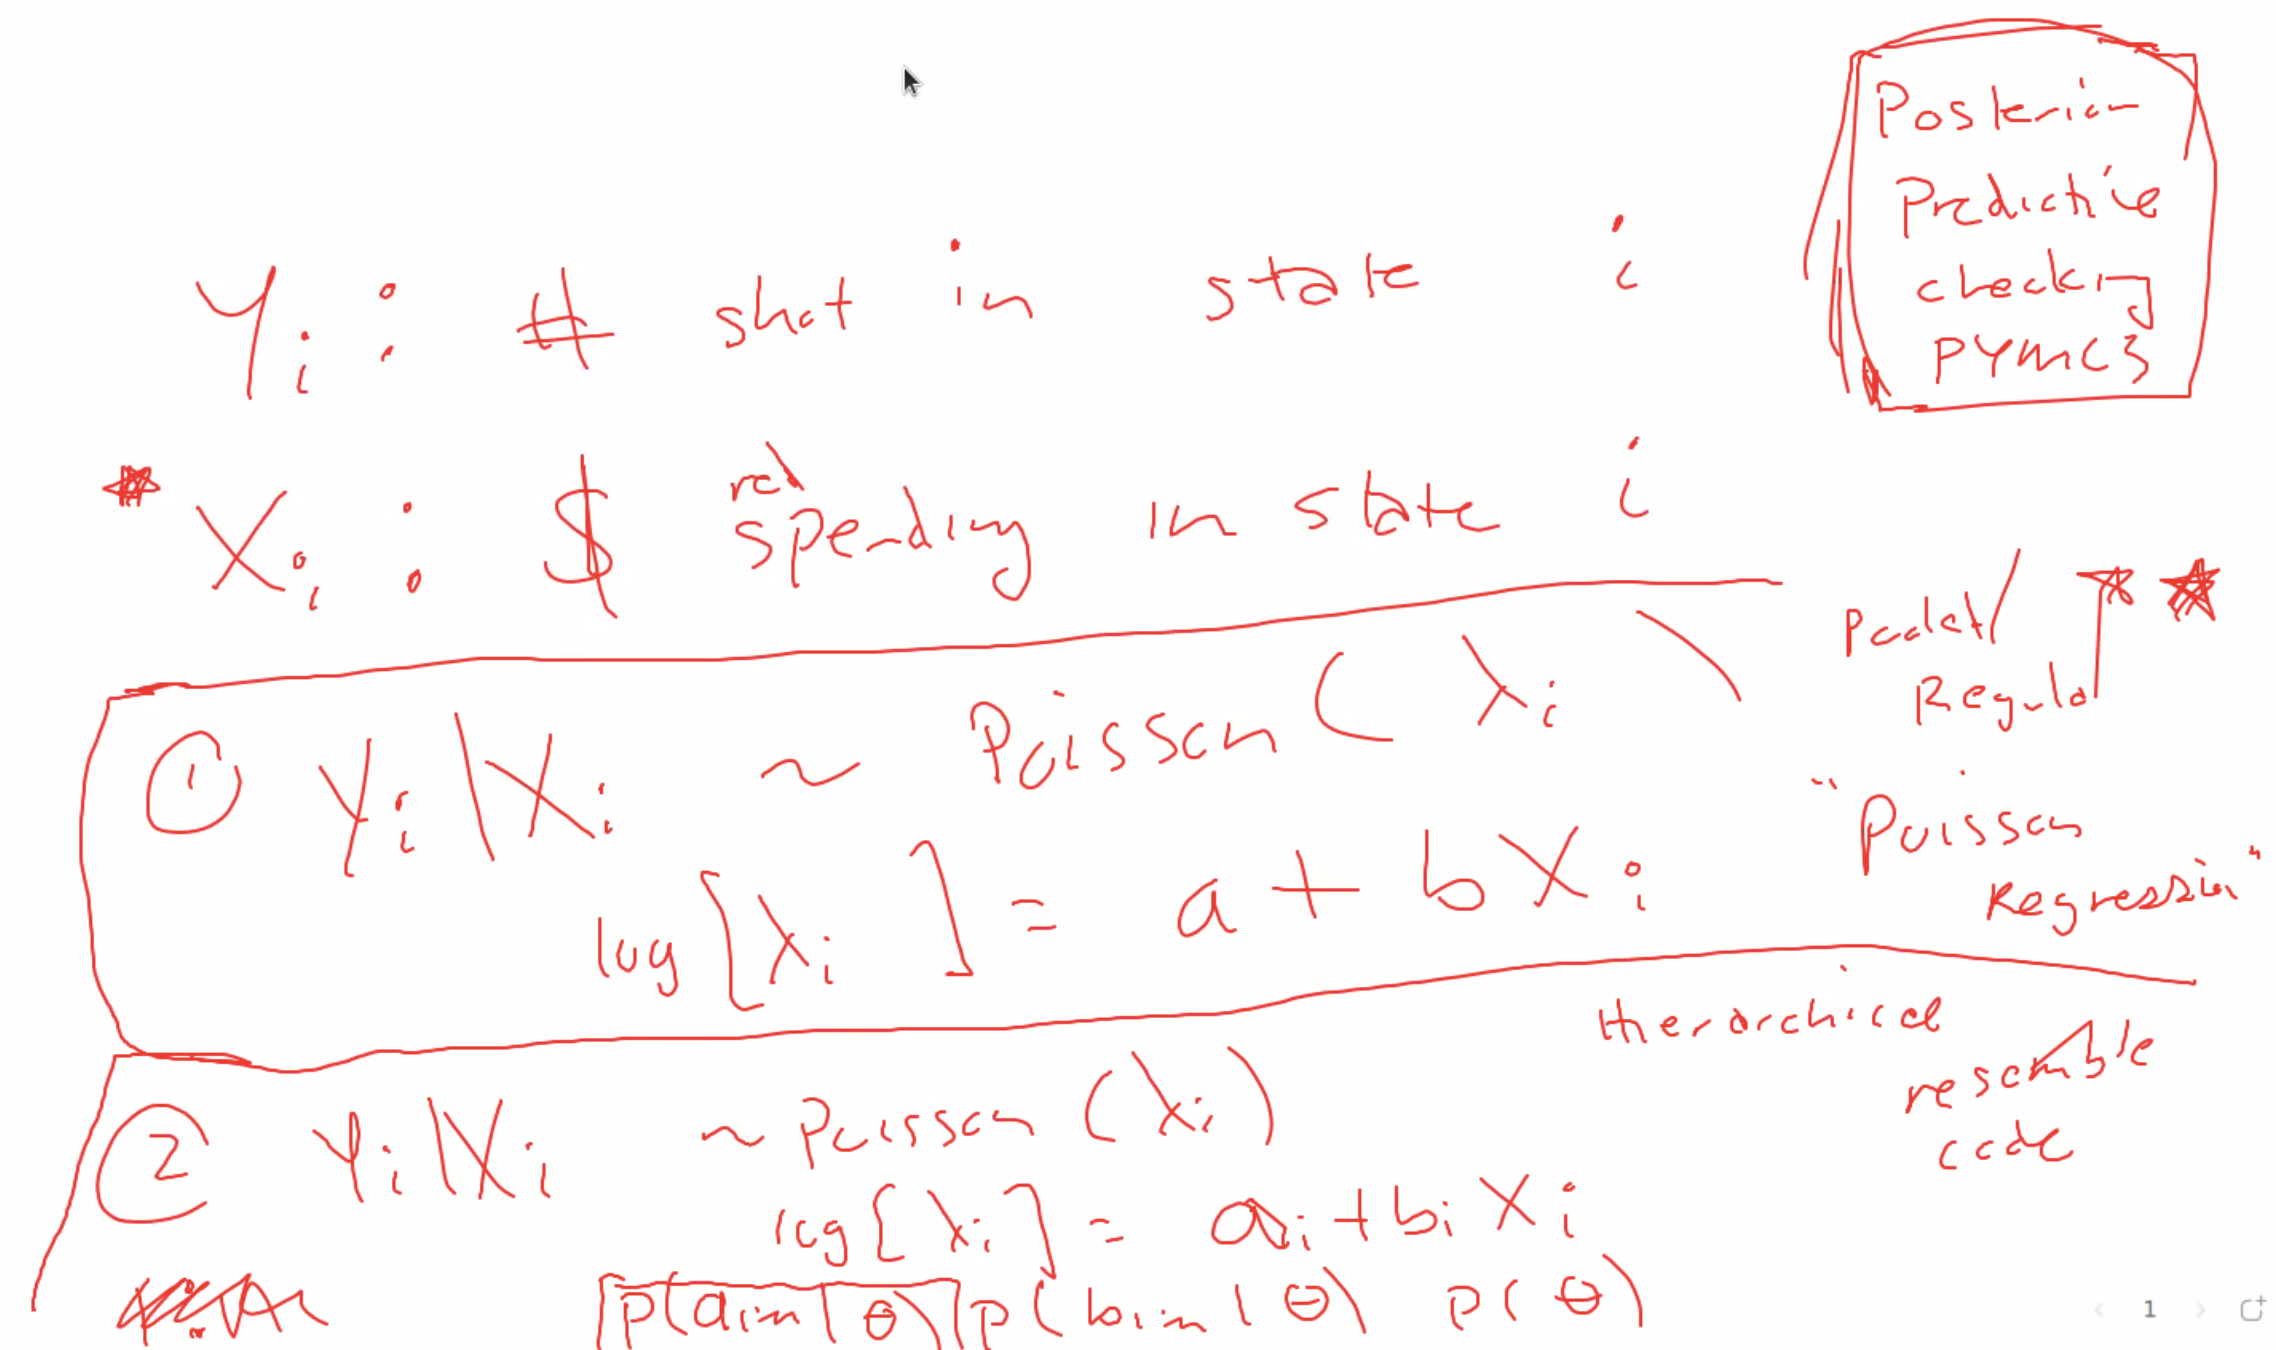

Poisson distribution is useful when counting things. In this case, we're counting the number of victims in all shootings (from 2020 to 7/8/22) for each state. Model requires using discrete non-negative numbers: {0,1,2,3...} (aka count data).

https://learning.oreilly.com/library/view/bayesian-analysis-with/9781789341652/2252e56c-3e2d-40ae-812b-38a5bd4e63d2.xhtml

https://www.youtube.com/watch?v=ZxR3mw-Znzc

Workflow:  
1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence (cool stuff?)
6. Run posterior predictive check
7. Improve model


In [94]:
#import libraries
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from formulae import design_matrices
import arviz as az
import bambi as bmb
import math

# Load data

In [13]:
df = pd.read_csv("state_level_data.csv")
party = pd.read_csv("presidential_state_results_2020.csv")

In [14]:
#df.columns

In [20]:
#party

In [15]:
#drop index column
df = df[['state', 'total_involved', 'abbrev', 'democrat','republican']]

In [18]:
#add column for red/blue state (visualization purposes only)
df = df.join(other = party.set_index('state'), on = 'abbrev', how = 'left')

In [33]:
df

,state,total_involved,abbrev,democrat,republican,party
0,Alabama,195,AL,3.847529e+05,1.336843e+06,r
1,Alaska,18,AK,9.699815e+04,2.169688e+05,r
2,Arizona,106,AZ,9.079025e+07,6.144790e+07,b
3,Arkansas,127,AR,3.368742e+05,5.981153e+05,r
4,California,557,CA,1.067421e+07,8.769293e+06,b
5,Colorado,168,CO,4.200255e+06,1.118881e+06,b
6,Connecticut,50,CT,5.880892e+05,3.885284e+05,b
7,Delaware,43,DE,2.135545e+05,1.185754e+05,b
8,District of Columbia,156,DC,7.453544e+06,2.962742e+06,b
9,Florida,413,FL,2.289976e+08,1.205918e+08,r


In [22]:
#save df with party info
#df.to_csv('state_spending_with_party.csv')

# 1. Plot Data

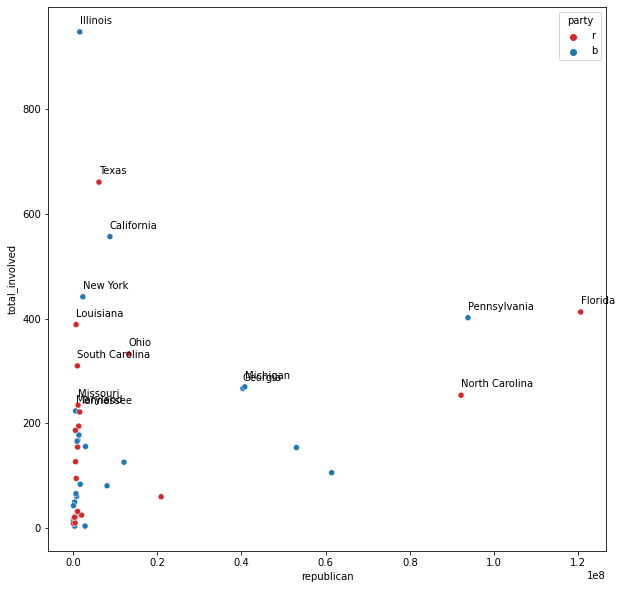

In [74]:
#define palette colors
palette = {'b':'tab:blue',
          'r':'tab:red'}

#scatterplot
plt.figure(figsize = (10,10))
sns.scatterplot(data = df, 
                x = 'republican', 
                y = 'total_involved',
                hue = 'party',
               palette = palette)

#add text labels
for i in range(df.shape[0]):
    if df.total_involved[i] > 200:
        plt.text(x = df.republican[i]+5,
                y = df.total_involved[i]+15,
                s = df.state[i],
                fontdict=dict(color = 'black', size = 10))

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

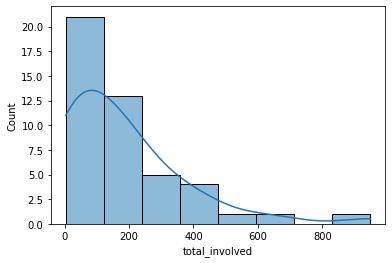

In [79]:
sns.histplot(data = df, x = 'total_involved', kde = True)

<AxesSubplot:xlabel='total_involved', ylabel='Count'>

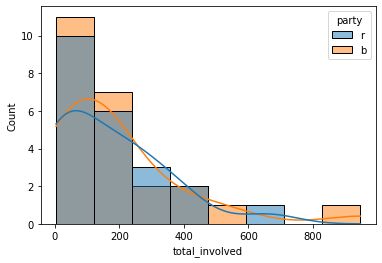

In [77]:
sns.histplot(data = df, x = 'total_involved', kde = True, hue = 'party')

# 2. Build Model

The probability mass function of Poisson distribution is as follows:  

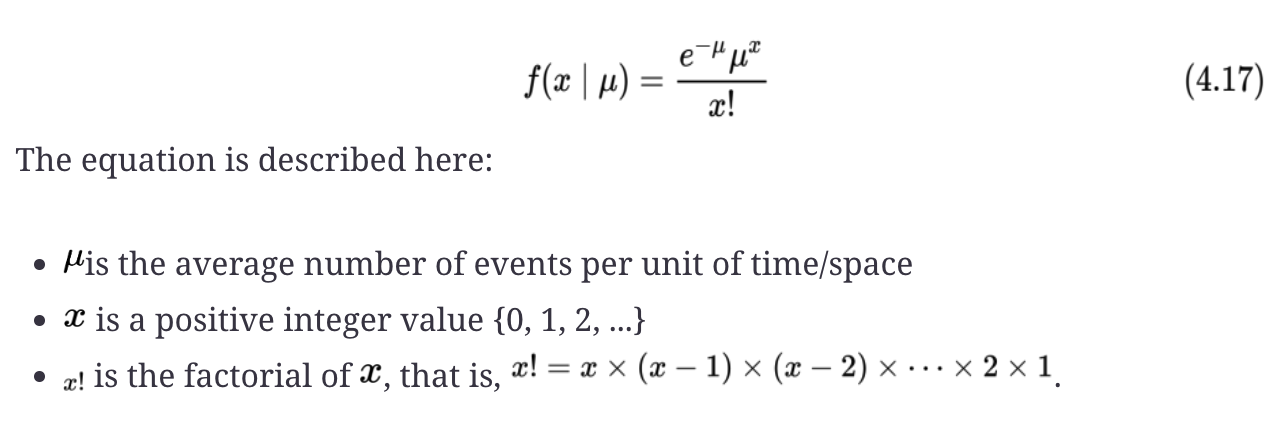

In [87]:
#create model (full formulae formulation)
fml = 'total_involved ~ republican'

In [88]:
#create design matrices
dm = design_matrices(fml, df, na_action = 'error')

In [89]:
mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

In [93]:
mx_ex.head()

,Intercept,republican
0,1.0,1336842.71
1,1.0,216968.84
2,1.0,61447902.91
3,1.0,598115.27
4,1.0,8769292.52


In [95]:
mx_en.head()

,total_involved
0,195
1,18
2,106
3,127
4,557


In [98]:
#create model

with pm.Model() as pois_log:
    
    #define priors
    b0 = pm.Normal("Intercept", mu = 0, sigma = 100)
    b1 = pm.Normal("rep_spend", mu = 0, sigma = 1000000)

    
    #define logistic model
    log_lambda = (b0 + b1*mx_ex['republican'].values)
    
    #define poisson likelihood
    y = pm.Poisson("y", 
                   mu = pm.math.exp(log_lambda), 
                   observed = mx_en['total_involved'].values)

In [99]:
#sample model
with pois_log:
    test = pm.sample()

<ipython-input-99-01998e3b284a>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  test = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Intercept': array(0.97636709), 'rep_spend': array(0.49054276)}

Initial evaluation results:
Intercept    -5.52
rep_spend   -14.73
y              NaN
Name: Log-probability of test_point, dtype: float64

In [ ]:
az.plot_trace()